# MVP - Pós Graduação em Engenharia de Software (PUC Rio)
# Sprint Qualidade de Software, Segurança e Sistemas Inteligentes

O objetivo desse notebook é explorar os dados de uma base da Nasa para classificar se um objeto em órbita da terra pode vir a causar uma catástrofe global.

Colunas do dataset:

- id: identificador único do asteróide
- name: nome dado pela Nasa
- est_diameter_min: Diâmetro mínimo estimado em km
- est_diameter_max: Diâmetro máximo estimado em km
- relative_velocity: Velocidade Relativa da Terra, em km/h
- miss_distance: Distância que o asteróide passou da terra, em km



In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

## Explorando os dados

Carga

In [2]:
url = "https://media.githubusercontent.com/media/NephilimJaeger/mvp-model-fullstack/refs/heads/main/data/neo.csv"
df = pd.read_csv(url, delimiter=',')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
#Tipos dos dados, quantidade de linhas, quantidade de colunas e quantidade de dados não nulos por coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [4]:
#Checando a quantidade de dados nulos
null_qnty = df.isnull().sum().to_frame('Missing Values')
null_qnty

,Missing Values
id,0
name,0
est_diameter_min,0
est_diameter_max,0
relative_velocity,0
miss_distance,0
orbiting_body,0
sentry_object,0
absolute_magnitude,0
hazardous,0


In [5]:
# Procurando por dados duplicados
has_duplicates = df.duplicated().any()
print(has_duplicates)

False


In [6]:
#Estatísticas básicas sobre os dados
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


É possível notar valores altos de desvio padrão, indicando que os objetos presentes no conjunto de dados tem uma variedade muito grande em termos de tamanho, velocidade e distância que passam da Terra. Muito provavelmente essas colunas apresentam outliers que pode interferir no resultado do modelo.

## Limpeza e preparação

In [7]:
# Excluindo colunas irrelevantes para o treinamento do modelo
df = df.drop(["id","name","orbiting_body"], axis=1)

<Axes: >

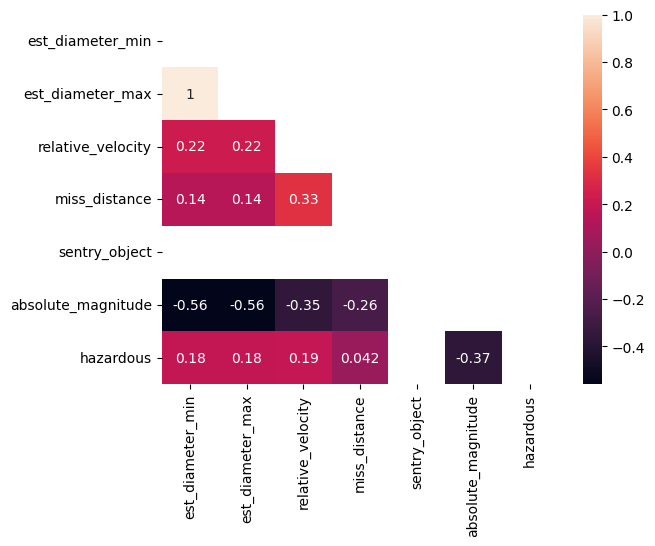

In [8]:
#Matriz de correlação para ver quais atributos tem maior correlação com o atributo de interesse
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,mask = mask ,annot=True)

In [9]:
#Mantendo variáveis que tem correlação maior que 0.1 com a variável de interesse
threshold = 0.1
columns_to_keep = correlation_matrix['hazardous'].abs() > threshold
columns_to_keep['hazardous'] = True
columns_to_keep = columns_to_keep[columns_to_keep].index
df = df[columns_to_keep]

In [10]:
df.columns

Index(['est_diameter_min', 'est_diameter_max', 'relative_velocity',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [11]:
#A luminosidade do objeto não vai interferir na classificação, então vamos remover essa coluna
#A coluna de estimativa de tamanho máximo também não é interesante, uma vez que já temos o tamanho mínimo do objeto
df = df.drop(["absolute_magnitude","est_diameter_max"], axis=1)

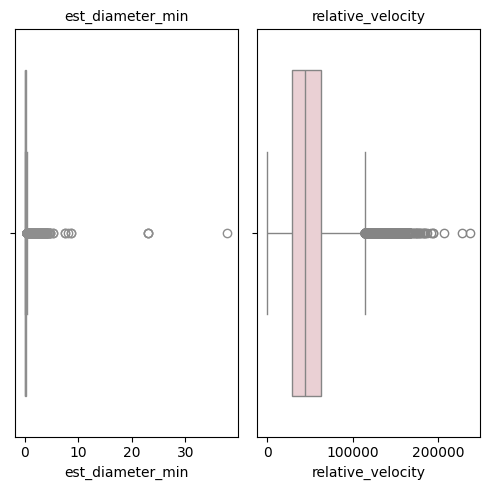

In [12]:
#Procurando por outliers
numerical = df.select_dtypes(include=['int', 'float']).copy()
rows, cols = 1,2
cube_palette = sns.cubehelix_palette(gamma=.5)

fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
axes = axes.flatten()

for i, col in enumerate(numerical.columns):
    if i < len(axes):
        sns.boxplot(x=df[col], ax=axes[i], color=cube_palette[i % len(cube_palette)])
        axes[i].set_title(col, fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
# Como pôde ser visto no output da célula anterior, temos outliers nas colunas 'est_diameter_min' e 'relative_velocity'
# Os valores serão removidos pela função abaixo
def handle_outliers(df, columns):
    
    """ Remove outliers do dataframe """

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

columns_to_handel= ['est_diameter_min','relative_velocity']
data = handle_outliers(df, columns_to_handel)

### Modelagem

#### Treino e validação do modelo

In [14]:
# Separando o dataset em treino e teste
target = df.hazardous.astype(int)

test_size = 0.20
seed = 10

X = data.drop("hazardous",axis=1)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)

scoring = "accuracy"
num_particoes = 7
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

In [15]:
def evaluate(to_eval, X_train, y_train, kfold, scoring):
    """
    Função para avaliar modelos de machine learning

    Parâmetros:
        to_eval: lista de tuplas contendo o nome do modelo e o modelo ou pipeline a ser avaliado
        X_train: features de treino
        y_train: target de treino
        kfold: objeto de validação cruzada
        scoring: métrica de avaliação
    """
    results = []
    names = []
    for name, model_or_pipeline in to_eval:
        cv_results = cross_val_score(model_or_pipeline, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results, names

def create_pipelines(models, scalers, dataset_types):
    """
    Cria pipelines para rodar modelos com diferentes tipos de datasets

    Parâmetros:
        models: lista de tuplas contendo o nome do modelo e o modelo
        scalers: lista de tuplas contendo o nome do scaler e o scaler
        dataset_types: lista contendo os tipos de dataset a serem avaliados
    """
    pipelines = []
    for dataset_type in dataset_types:
        if dataset_type == 'original':
            # Dados originais (sem scaler)
            pipelines.extend([(f'{model[0]}-orig', Pipeline([model])) for model in models])

        elif dataset_type == 'padronizado':
            # Dados padronizados
            pipelines.extend([(f'{model[0]}-padr', Pipeline([scalers[0], model])) for model in models])
        
        elif dataset_type == 'normalizado':
            # Dados normalizados
            pipelines.extend([(f'{model[0]}-norm', Pipeline([scalers[1], model])) for model in models])
    return pipelines

KNN-orig: 0.893873 (0.000628)
CART-orig: 0.883952 (0.001643)
NB-orig: 0.902681 (0.000041)
SVM-orig: 0.902681 (0.000041)
KNN-padr: 0.889594 (0.002758)
CART-padr: 0.883787 (0.001216)
NB-padr: 0.860282 (0.003493)
SVM-padr: 0.902681 (0.000041)
KNN-norm: 0.890461 (0.002654)
CART-norm: 0.883828 (0.001741)
NB-norm: 0.860282 (0.003493)
SVM-norm: 0.902681 (0.000041)


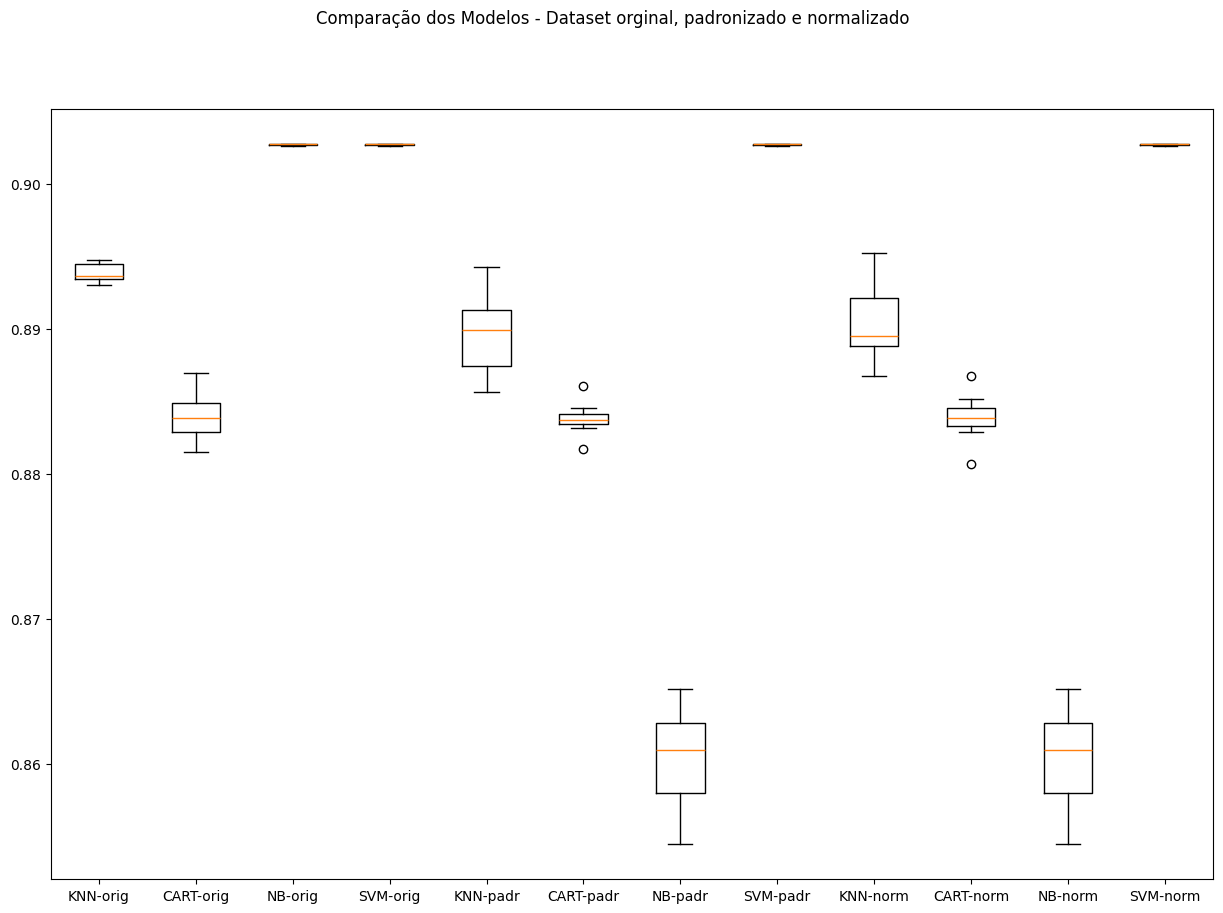

In [16]:
np.random.seed(10)

#definindo os tipos de modelos que serão avaliados e criando uma lista com eles

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

models = [knn, cart, naive_bayes, svm]

#Steps para o pipeline usando dados padronizados e normalizados
standard_scaler = ('StandardScaler', StandardScaler()) 
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

scalers = [standard_scaler, min_max_scaler]

#Tipos de datasets que serão avaliados
dataset_types = ['original', 'padronizado', 'normalizado']

#Cria um pipeline para cada modelo e tipo de dataset
pipelines = create_pipelines(models, scalers, dataset_types)

results, names = evaluate(pipelines, X_train, y_train, kfold, scoring)

fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- Os modelos tiveram uma ótima acurácia, todos acima de 85% com destaque para o SVM que teve a maior acurácia entre eles, praticamente igual para os dados originais, normalizados e padronizados.
- Destaque para o modelo de Naive Bayes que teve uma queda de performance com os dados tratados. Apenas esse modelo teve uma diferença significativa com os diferentes tratamentos nos dados.

Modelagem: Otimização de Hiper parâmetros

In [19]:
#Definição dos parâmetros para o GridSearch
param_grids = {
            'KNN': {
                'KNN__n_neighbors': [3, 5, 7, 9, 11],
                'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
                'KNN__weights': ['uniform', 'distance']

            },
            'CART': {
                'CART__criterion': ['gini', 'entropy'],
                'CART__max_depth': [None, 10, 20, 30],
                'CART__min_samples_split': [2, 5, 10],
                'CART__min_samples_leaf': [1, 2, 4]
            },
            'NB': {
                'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            },
            'SVM': {
                'SVM__C': [0.1, 1, 10],
                'SVM__kernel': ['rbf', 'linear', 'poly']
            }
        }

#usando apenas os dados originais
pipelines_orig = [(name, model) for name, model in pipelines if '-orig' in name]
for name, model in pipelines_orig:
    model_name = name.split('-')[0]
    gs = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=kfold, scoring=scoring)
    gs.fit(X_train, y_train)
    print(f'Melhor parâmetro para o modelo {name}: {gs.best_params_} com acurácia de {gs.best_score_}')

Melhor parâmetro para o modelo KNN-orig: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11, 'KNN__weights': 'uniform'} com acurácia de 0.9016898737298195
Melhor parâmetro para o modelo CART-orig: {'CART__criterion': 'entropy', 'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10} com acurácia de 0.9038503996972309
Melhor parâmetro para o modelo NB-orig: {'NB__var_smoothing': 1e-09} com acurácia de 0.9026806855942989
